In [4]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve

from sklearn.utils import shuffle

import optuna

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from joblib import dump

import time

In [5]:
train_df = pd.read_csv('data/processed_train.csv')
test_df = pd.read_csv('data/processed_test.csv')

In [6]:
train_df = shuffle(train_df).reset_index(drop=True)
test_df = shuffle(test_df).reset_index(drop=True)

In [7]:
x = train_df['text'].values
y = train_df['label'].values

x_test = test_df['text'].values
y_test = test_df['label'].values

In [8]:
x_train, x_train_thresh, y_train, y_train_thresh, = train_test_split(x, 
                                                                     y, 
                                                                     test_size=0.1, 
                                                                     stratify=y)

In [9]:
def predict_w_threshold(estimator, x, threshold=.5):
    return (estimator.predict_proba(x)[:,1] >= threshold).astype(int)

### Naive Bayes

#### Baseline

In [ ]:
baseline_nb = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),   
                        ('nb', MultinomialNB())])

In [ ]:
scores = cross_val_score(baseline_nb, 
                         x_train, 
                         y_train, 
                         cv=5, 
                         scoring='roc_auc', 
                         n_jobs=-1, 
                         verbose= 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished


In [ ]:
print(scores)
print('ROC AUC score = %.4f +/- %.4f'%(np.array(scores).mean(), np.array(scores).std()))

[0.93547398 0.93884504 0.92992672 0.93464237 0.9321118 ]
ROC AUC score = 0.9342 +/- 0.0030


#### Hyperparameter Optimization

In [ ]:
opt_nb = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),   
                   ('nb', MultinomialNB())])

In [ ]:
def objective(trial):
  tfidf__max_ngrams = trial.suggest_int('tfidf__max_ngrams', 1, 3)
  tfidf__max_df = trial.suggest_uniform('tfidf__max_df', 0.60, 0.95)
  tfidf__min_df = trial.suggest_int('tfidf__min_df', 1, 12)

  nb__alpha = trial.suggest_uniform('nb__alpha', 0.0, 1.0)

  params = {
      'tfidf__ngram_range': (1, tfidf__max_ngrams),
      'tfidf__max_df': tfidf__max_df,
      'tfidf__min_df': tfidf__min_df,
      'nb__alpha': nb__alpha,
  }
  
  opt_nb.set_params(**params)

  return np.mean(cross_val_score(opt_nb, 
                                 x_train, 
                                 y_train, 
                                 cv=5, 
                                 scoring='roc_auc', 
                                 n_jobs=-1))

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=600, n_jobs=-1)

[I 2020-12-17 00:59:33,880] A new study created in memory with name: no-name-752d0641-4b5e-432c-beaa-cc51eb9190e4
[I 2020-12-17 01:00:10,635] Trial 0 finished with value: 0.925105224691358 and parameters: {'tfidf__max_ngrams': 1, 'tfidf__max_df': 0.7780643393726996, 'tfidf__min_df': 3, 'nb__alpha': 0.37746372850136223}. Best is trial 0 with value: 0.925105224691358.
[I 2020-12-17 01:00:11,271] Trial 1 finished with value: 0.925105224691358 and parameters: {'tfidf__max_ngrams': 1, 'tfidf__max_df': 0.926091046371308, 'tfidf__min_df': 12, 'nb__alpha': 0.06655215205583953}. Best is trial 0 with value: 0.925105224691358.
[I 2020-12-17 01:01:33,594] Trial 2 finished with value: 0.9342091456790124 and parameters: {'tfidf__max_ngrams': 1, 'tfidf__max_df': 0.6162428253758513, 'tfidf__min_df': 1, 'nb__alpha': 0.33284184945981843}. Best is trial 2 with value: 0.9342091456790124.
[I 2020-12-17 01:02:05,723] Trial 3 finished with value: 0.9398458469135802 and parameters: {'tfidf__max_ngrams': 2, 't

In [ ]:
optuna.visualization.plot_contour(study, params=['tfidf__max_ngrams',
                                                 'tfidf__max_df',
                                                 'tfidf__min_df'])

In [ ]:
optuna.visualization.plot_slice(study, ['nb__alpha'])

In [ ]:
print(study.best_params)

{'tfidf__max_ngrams': 2, 'tfidf__max_df': 0.6100772564647808, 'tfidf__min_df': 2, 'nb__alpha': 0.737996055994291}


In [ ]:
params = {
    'tfidf__ngram_range': (1, study.best_params['tfidf__max_ngrams']),
    'tfidf__max_df': study.best_params['tfidf__max_df'],
    'tfidf__min_df': study.best_params['tfidf__min_df'],
    'nb__alpha': study.best_params['nb__alpha']
}
opt_nb.set_params(**params)

scores = cross_val_score(opt_nb, 
                         x_train, 
                         y_train, 
                         cv=5, 
                         scoring='roc_auc', 
                         n_jobs=-1, 
                         verbose= 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.9s finished


In [ ]:
print(scores)
print('ROC AUC score = %.4f +/- %.4f'%(np.array(scores).mean(), np.array(scores).std()))

[0.94613491 0.9482319  0.94075042 0.94568672 0.94293807]
ROC AUC score = 0.9447 +/- 0.0026


In [ ]:
opt_nb.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.6100772564647808,
                                 max_features=None, min_df=2,
                                 ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('nb',
                 MultinomialNB(alpha=0.737996055994291, class_prior=None,
                     

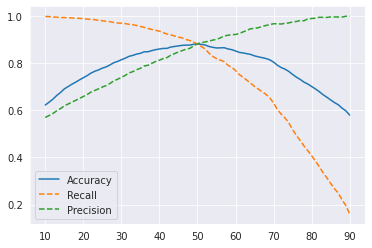

In [ ]:
threshold_acc = {}
threshold_recall = {}
threshold_precision = {}
for threshold in range(10, 91, 1):
    y_pred = predict_w_threshold(opt_nb, x_train_thresh, threshold/100)

    acc = accuracy_score(y_train_thresh, y_pred)
    recall = recall_score(y_train_thresh, y_pred)
    precision = precision_score(y_train_thresh, y_pred)
    
    threshold_acc[threshold] = acc
    threshold_recall[threshold] = recall
    threshold_precision[threshold] = precision

ax = sns.lineplot(x=threshold_acc.keys(), y=threshold_acc.values())
ax = sns.lineplot(x=threshold_recall.keys(), y=threshold_recall.values(), ax=ax)
ax = sns.lineplot(x=threshold_precision.keys(), y=threshold_precision.values(), ax=ax)

ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")

plt.legend(labels=['Accuracy', 'Recall', 'Precision'])

* Threshold = 0.50

In [ ]:
opt_nb.fit(x, y)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.6100772564647808,
                                 max_features=None, min_df=2,
                                 ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('nb',
                 MultinomialNB(alpha=0.737996055994291, class_prior=None,
                     

#### Model Evaluation

Accuracy = 0.8478


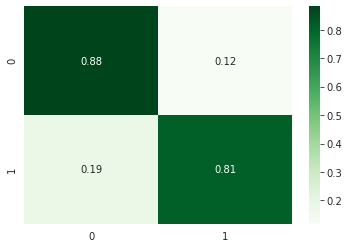

In [ ]:
y_pred = predict_w_threshold(opt_nb, x_test, 0.5)

print('Accuracy = %.4f'%(accuracy_score(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Greens')

In [ ]:
feature_names = opt_nb['tfidf'].get_feature_names()
print('%i features'%(len(feature_names)))

306028 features


Text(0.5, 0.98, 'Probability of features given classes')

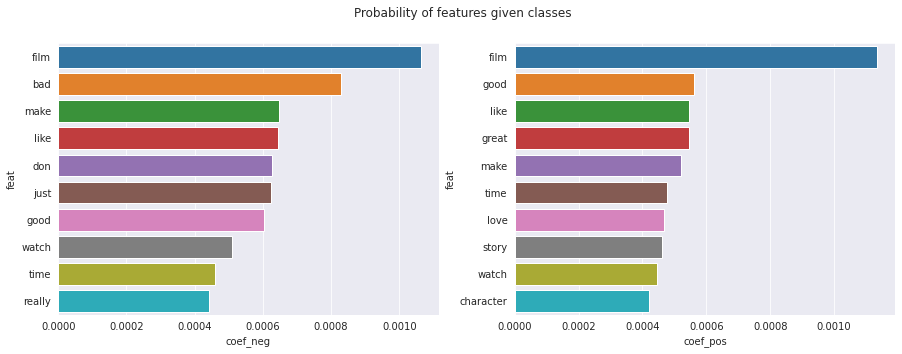

In [ ]:
importances_df = pd.DataFrame()

importances_df['feat'] = feature_names

importances_df['coef_neg'] = np.e**opt_nb['nb'].feature_log_prob_[0, :]
importances_df['coef_pos'] = np.e**opt_nb['nb'].feature_log_prob_[1, :]

plt.figure(figsize=(15, 5))

importances_df = importances_df.sort_values('coef_neg', ascending=False)
plt.subplot(1, 2, 1)
sns.barplot(data=importances_df.head(10), x='coef_neg', y='feat')

importances_df = importances_df.sort_values('coef_pos', ascending=False)
plt.subplot(1, 2, 2)
sns.barplot(data=importances_df.head(10), x='coef_pos', y='feat')

plt.suptitle('Probability of features given classes')

### Logistic Regression

#### Baseline

In [ ]:
baseline_lr = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                        ('lr', LogisticRegression(random_state=42))])

In [ ]:
scores = cross_val_score(baseline_lr, 
                         x_train, 
                         y_train, 
                         cv=5, 
                         scoring='roc_auc', 
                         n_jobs=-1, 
                         verbose= 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s finished


In [ ]:
print(scores)
print('ROC AUC score = %.4f +/- %.4f'%(np.array(scores).mean(), np.array(scores).std()))

[0.95056474 0.95160711 0.94977758 0.95363911 0.94665343]
ROC AUC score = 0.9504 +/- 0.0023


#### Hyperparameter Optimization

In [ ]:
opt_lr = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),   
                   ('lr', LogisticRegression(random_state=42))])

In [ ]:
def objective(trial):
  tfidf__max_ngrams = trial.suggest_int('tfidf__max_ngrams', 1, 3)
  tfidf__max_df = trial.suggest_uniform('tfidf__max_df', 0.60, 0.95)
  tfidf__min_df = trial.suggest_int('tfidf__min_df', 1, 12)

  lr__max_iter = trial.suggest_int('lr__max_iter', 70, 400)
  lr__C = trial.suggest_uniform('lr__C', 0.8, 1.0)

  params = {
      'tfidf__ngram_range': (1, tfidf__max_ngrams),
      'tfidf__max_df': tfidf__max_df,
      'tfidf__min_df': tfidf__min_df,
      'lr__max_iter': lr__max_iter,
      'lr__C': lr__C
  }
  
  opt_lr.set_params(**params)

  return np.mean(cross_val_score(opt_lr, 
                                 x_train, 
                                 y_train, 
                                 cv=5, 
                                 scoring='roc_auc', 
                                 n_jobs=-1))

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=900, n_jobs=-1)

[I 2020-12-17 01:16:16,445] A new study created in memory with name: no-name-a1d940ca-bff9-4ef6-9234-f7fb4fb99d91
[I 2020-12-17 01:18:43,653] Trial 1 finished with value: 0.9513082074074074 and parameters: {'tfidf__max_ngrams': 2, 'tfidf__max_df': 0.6854232519660124, 'tfidf__min_df': 10, 'lr__max_iter': 329, 'lr__C': 0.8516885880135042}. Best is trial 1 with value: 0.9513082074074074.
[I 2020-12-17 01:18:43,782] Trial 0 finished with value: 0.9513082074074074 and parameters: {'tfidf__max_ngrams': 3, 'tfidf__max_df': 0.6816326305838684, 'tfidf__min_df': 5, 'lr__max_iter': 309, 'lr__C': 0.842341937350733}. Best is trial 1 with value: 0.9513082074074074.
[I 2020-12-17 01:23:40,196] Trial 3 finished with value: 0.9515349333333333 and parameters: {'tfidf__max_ngrams': 3, 'tfidf__max_df': 0.9472455936379497, 'tfidf__min_df': 6, 'lr__max_iter': 99, 'lr__C': 0.8630181476546867}. Best is trial 3 with value: 0.9515349333333333.
[I 2020-12-17 01:23:40,317] Trial 2 finished with value: 0.951699871

In [ ]:
optuna.visualization.plot_contour(study, params=['tfidf__max_ngrams',
                                                 'tfidf__max_df',
                                                 'tfidf__min_df'])

In [ ]:
optuna.visualization.plot_contour(study, params=['lr__C',
                                                 'lr__max_iter'])

In [ ]:
print(study.best_params)

{'tfidf__max_ngrams': 3, 'tfidf__max_df': 0.8575339863886443, 'tfidf__min_df': 8, 'lr__max_iter': 354, 'lr__C': 0.8878274412708861}


In [ ]:
params = {
    'tfidf__ngram_range': (1, study.best_params['tfidf__max_ngrams']),
    'tfidf__max_df': study.best_params['tfidf__max_df'],
    'tfidf__min_df': study.best_params['tfidf__min_df'],
    'lr__max_iter': study.best_params['lr__max_iter'],
    'lr__C': study.best_params['lr__C']
}
opt_lr.set_params(**params)

scores = cross_val_score(opt_lr, 
                         x_train, 
                         y_train, 
                         cv=5, 
                         scoring='roc_auc', 
                         n_jobs=-1, 
                         verbose= 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


In [ ]:
print(scores)
print('ROC AUC score = %.4f +/- %.4f'%(np.array(scores).mean(), np.array(scores).std()))

[0.95219358 0.9529037  0.95002311 0.95483536 0.94881699]
ROC AUC score = 0.9518 +/- 0.0021


In [ ]:
opt_lr.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8575339863886443,
                                 max_features=None, min_df=8,
                                 ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=F...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=0.8878274412708861, class_weight=None,
                    

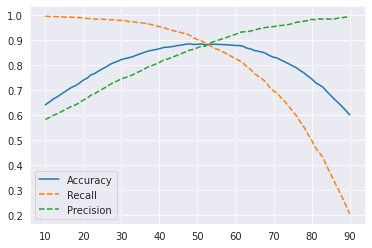

In [ ]:
threshold_acc = {}
threshold_recall = {}
threshold_precision = {}
for threshold in range(10, 91, 1):
    y_pred = predict_w_threshold(opt_lr, x_train_thresh, threshold/100)

    acc = accuracy_score(y_train_thresh, y_pred)
    recall = recall_score(y_train_thresh, y_pred)
    precision = precision_score(y_train_thresh, y_pred)
    
    threshold_acc[threshold] = acc
    threshold_recall[threshold] = recall
    threshold_precision[threshold] = precision

ax = sns.lineplot(x=threshold_acc.keys(), y=threshold_acc.values())
ax = sns.lineplot(x=threshold_recall.keys(), y=threshold_recall.values(), ax=ax)
ax = sns.lineplot(x=threshold_precision.keys(), y=threshold_precision.values(), ax=ax)

ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")

plt.legend(labels=['Accuracy', 'Recall', 'Precision'])

* Threshold = 0.51

In [ ]:
opt_lr.fit(x, y)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8575339863886443,
                                 max_features=None, min_df=8,
                                 ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=F...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=0.8878274412708861, class_weight=None,
                    

#### Model Evaluation

Accuracy = 0.8803


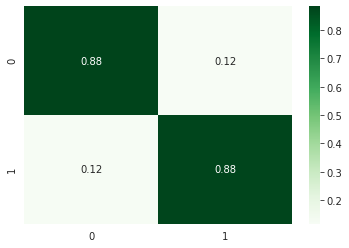

In [ ]:
y_pred = predict_w_threshold(opt_lr, x_test, 0.51)

print('Accuracy = %.4f'%(accuracy_score(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Greens')

In [ ]:
feature_names = opt_lr['tfidf'].get_feature_names()
print('%i features'%(len(feature_names)))

48357 features


Text(0.5, 1.0, 'Coefficients of the features')

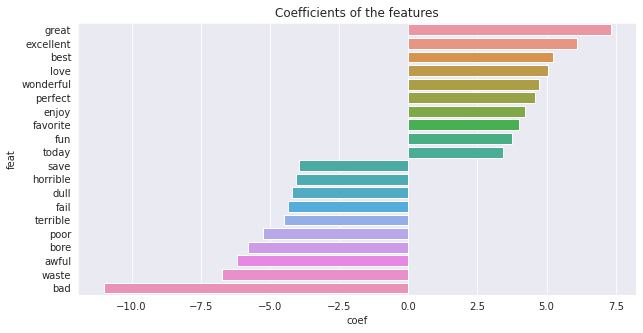

In [ ]:
importances_df = pd.DataFrame()

importances_df['feat'] = feature_names
importances_df['coef'] = opt_lr['lr'].coef_[0]

importances_df = importances_df.sort_values('coef', ascending=False)
top_feats = pd.concat([importances_df.head(10), importances_df.tail(10)])

plt.figure(figsize=(10, 5))

sns.barplot(data=top_feats, x='coef', y='feat')
plt.title('Coefficients of the features')

### LGBM

##### Baseline

In [10]:
baseline_lgb = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),   
                         ('lgb', LGBMClassifier(random_state=42, n_jobs=-1))])

In [11]:
scores = cross_val_score(baseline_lgb, 
                         x_train, 
                         y_train, 
                         cv=5, 
                         scoring='roc_auc', 
                         n_jobs=-1, 
                         verbose= 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


In [12]:
print(scores)
print('ROC AUC score = %.4f +/- %.4f'%(np.array(scores).mean(), np.array(scores).std()))

[0.92880938 0.92713185 0.93990933 0.92946884 0.92609679]
ROC AUC score = 0.9303 +/- 0.0050


#### Hyperparameter Optimization

In [13]:
opt_lgb = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),   
                    ('lgb', LGBMClassifier(random_state=42, n_jobs=-1))])

In [18]:
def objective(trial):
  tfidf__max_ngrams = trial.suggest_int('tfidf__max_ngrams', 1, 3)
  tfidf__max_df = trial.suggest_uniform('tfidf__max_df', 0.60, 0.95)
  tfidf__min_df = trial.suggest_int('tfidf__min_df', 1, 12)

  lgb__n_estimators = trial.suggest_int('lgb__n_estimators', 70, 500)
  lgb__max_depth = trial.suggest_int('lgb__max_depth', 5, 20)
  lgb__num_leaves = trial.suggest_int('lgb__num_leaves', 25, 40)
  lgb__learning_rate = trial.suggest_loguniform('lgb__learning_rate', 1e-4, 1e-1)
  lgb__colsample_bytree = trial.suggest_uniform('lgb__colsample_bytree', 0.85, 1.0)
  lgb__min_child_samples = trial.suggest_int('lgb__min_child_samples', 10, 50)
  lgb__subsample_for_bin= trial.suggest_int('lgb__subsample_for_bin', 1000, 8000)

  params = {
      'tfidf__ngram_range': (1, tfidf__max_ngrams),
      'tfidf__max_df': tfidf__max_df,
      'tfidf__min_df': tfidf__min_df,
      'lgb__n_estimators': lgb__n_estimators,
      'lgb__num_leaves': lgb__num_leaves,
      'lgb__learning_rate': lgb__learning_rate,
      'lgb__colsample_bytree': lgb__colsample_bytree,
      'lgb__min_child_samples': lgb__min_child_samples,
      'lgb__subsample_for_bin': lgb__subsample_for_bin,
  }
  
  opt_lgb.set_params(**params)

  return np.mean(cross_val_score(opt_lgb, 
                                 x_train, 
                                 y_train, 
                                 cv=5, 
                                 scoring='roc_auc', 
                                 n_jobs=-1))

In [20]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=3000, n_jobs=-1)

[I 2020-12-17 20:09:09,465] A new study created in memory with name: no-name-fd7dd865-0339-427a-aa55-f7fea75a9372
[I 2020-12-17 20:21:04,465] Trial 1 finished with value: 0.8316842864197532 and parameters: {'tfidf__max_ngrams': 2, 'tfidf__max_df': 0.8995366692557372, 'tfidf__min_df': 12, 'lgb__n_estimators': 454, 'lgb__max_depth': 20, 'lgb__num_leaves': 33, 'lgb__learning_rate': 0.0002597345285413156, 'lgb__colsample_bytree': 0.8950800734433236, 'lgb__min_child_samples': 16, 'lgb__subsample_for_bin': 1605}. Best is trial 1 with value: 0.8316842864197532.
[I 2020-12-17 20:21:07,332] Trial 0 finished with value: 0.8316842864197532 and parameters: {'tfidf__max_ngrams': 3, 'tfidf__max_df': 0.7929984878168347, 'tfidf__min_df': 4, 'lgb__n_estimators': 127, 'lgb__max_depth': 12, 'lgb__num_leaves': 35, 'lgb__learning_rate': 0.0007406494503974075, 'lgb__colsample_bytree': 0.8910711838212627, 'lgb__min_child_samples': 50, 'lgb__subsample_for_bin': 7027}. Best is trial 1 with value: 0.83168428641

In [21]:
optuna.visualization.plot_contour(study, params=['tfidf__max_ngrams',
                                                 'tfidf__max_df',
                                                 'tfidf__min_df'])

In [22]:
optuna.visualization.plot_contour(study, params=['lgb__max_depth',
                                                 'lgb__num_leaves',
                                                 'lgb__min_child_samples', 
                                                 'lgb__subsample_for_bin'])

In [23]:
print(study.best_params)

{'tfidf__max_ngrams': 3, 'tfidf__max_df': 0.776903509156797, 'tfidf__min_df': 7, 'lgb__n_estimators': 495, 'lgb__max_depth': 19, 'lgb__num_leaves': 35, 'lgb__learning_rate': 0.07513983875568599, 'lgb__colsample_bytree': 0.9321140111641218, 'lgb__min_child_samples': 10, 'lgb__subsample_for_bin': 3860}


In [24]:
params = {
    'tfidf__ngram_range': (1, study.best_params['tfidf__max_ngrams']),
    'tfidf__max_df': study.best_params['tfidf__max_df'],
    'tfidf__min_df': study.best_params['tfidf__min_df'],
    'lgb__n_estimators': study.best_params['lgb__n_estimators'],
    'lgb__num_leaves': study.best_params['lgb__num_leaves'],
    'lgb__learning_rate': study.best_params['lgb__learning_rate'],
    'lgb__colsample_bytree': study.best_params['lgb__colsample_bytree'],
    'lgb__min_child_samples': study.best_params['lgb__min_child_samples'],
    'lgb__subsample_for_bin': study.best_params['lgb__subsample_for_bin'],
}
opt_lgb.set_params(**params)

scores = cross_val_score(opt_lgb, 
                         x_train, 
                         y_train, 
                         cv=5, 
                         scoring='roc_auc', 
                         n_jobs=-1, 
                         verbose= 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.2min finished


In [25]:
print(scores)
print('ROC AUC score = %.4f +/- %.4f'%(np.array(scores).mean(), np.array(scores).std()))

[0.94296514 0.94302479 0.95081402 0.94489067 0.94359388]
ROC AUC score = 0.9451 +/- 0.0030


In [26]:
opt_lgb.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.776903509156797,
                                 max_features=None, min_df=7,
                                 ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=Fa...
                                colsample_bytree=0.9321140111641218,
                                importance_type='split',
                                learning_rate=0.07513983875568599, max_depth=-1,
                                min_child_samples=10, min_child_weight=0.001,
                  

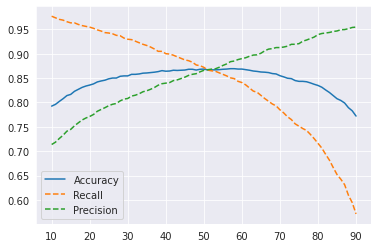

In [27]:
threshold_acc = {}
threshold_recall = {}
threshold_precision = {}
for threshold in range(10, 91, 1):
    y_pred = predict_w_threshold(opt_lgb, x_train_thresh, threshold/100)

    acc = accuracy_score(y_train_thresh, y_pred)
    recall = recall_score(y_train_thresh, y_pred)
    precision = precision_score(y_train_thresh, y_pred)
    
    threshold_acc[threshold] = acc
    threshold_recall[threshold] = recall
    threshold_precision[threshold] = precision

ax = sns.lineplot(x=threshold_acc.keys(), y=threshold_acc.values())
ax = sns.lineplot(x=threshold_recall.keys(), y=threshold_recall.values(), ax=ax)
ax = sns.lineplot(x=threshold_precision.keys(), y=threshold_precision.values(), ax=ax)

ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")

plt.legend(labels=['Accuracy', 'Recall', 'Precision'])

* Threshold = 0.51

In [37]:
opt_lgb.fit(x, y)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.776903509156797,
                                 max_features=None, min_df=7,
                                 ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=Fa...
                                colsample_bytree=0.9321140111641218,
                                importance_type='split',
                                learning_rate=0.07513983875568599, max_depth=-1,
                                min_child_samples=10, min_child_weight=0.001,
                  

#### Model Evaluation

Accuracy = 0.8751


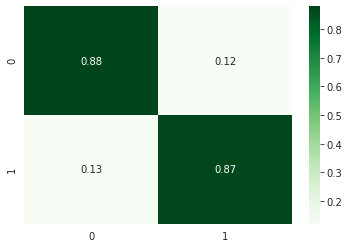

In [53]:
y_pred = predict_w_threshold(opt_lgb, x_test, 0.51)

print('Accuracy = %.4f'%(accuracy_score(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Greens')

In [40]:
feature_names = opt_lgb['tfidf'].get_feature_names()
print('%i features'%(len(feature_names)))

56311 features


In [58]:
opt_lgb['lgb'].feature_importances_

array([0, 0, 0, ..., 0, 0, 0])

Text(0.5, 1.0, 'Feature importances')

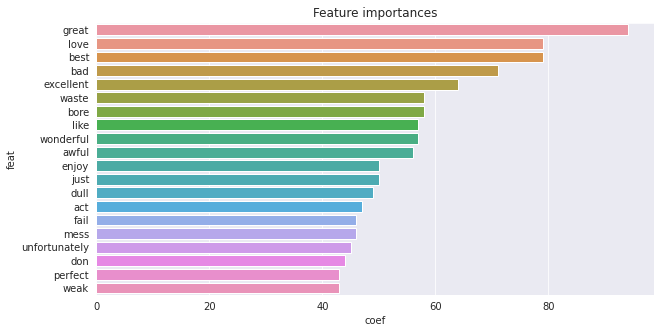

In [60]:
importances_df = pd.DataFrame()

importances_df['feat'] = feature_names
importances_df['coef'] = opt_lgb['lgb'].feature_importances_

importances_df = importances_df.sort_values('coef', ascending=False)
top_feats = pd.concat([importances_df.head(20)])

plt.figure(figsize=(10, 5))

sns.barplot(data=top_feats, x='coef', y='feat')
plt.title('Feature importances')

### Model Comparison

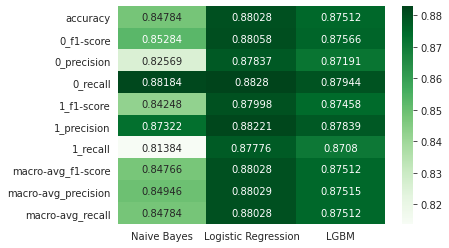

In [92]:
models = [(opt_nb, .5, 'Naive Bayes'), 
          (opt_lr, .51, 'Logistic Regression'), 
          (opt_lgb, .51, 'LGBM')]

model_scores = pd.DataFrame()

for model, thresh, name in models:
  y_pred = predict_w_threshold(model, x_test, thresh)
  report = classification_report(y_test, y_pred, output_dict=True)

  model_scores.loc['accuracy', name] = report['accuracy']

  model_scores.loc['0_f1-score', name] = report['0']['f1-score']
  model_scores.loc['0_precision', name] = report['0']['precision']
  model_scores.loc['0_recall', name] = report['0']['recall']

  model_scores.loc['1_f1-score', name] = report['1']['f1-score']
  model_scores.loc['1_precision', name] = report['1']['precision']
  model_scores.loc['1_recall', name] = report['1']['recall']

  model_scores.loc['macro-avg_f1-score', name] = report['macro avg']['f1-score']
  model_scores.loc['macro-avg_precision', name] = report['macro avg']['precision']
  model_scores.loc['macro-avg_recall', name] = report['macro avg']['recall']

sns.heatmap(model_scores, annot=True, cmap='Greens', fmt='.5g')

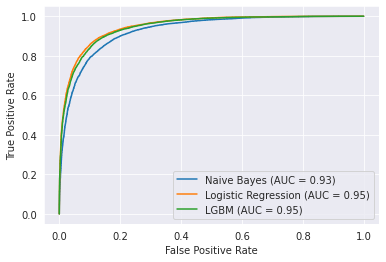

In [93]:
ax = plot_roc_curve(opt_nb, x_test, y_test, name='Naive Bayes')
ax = plot_roc_curve(opt_lr, x_test, y_test, ax = ax.ax_, name='Logistic Regression')
ax = plot_roc_curve(opt_lgb, x_test, y_test, ax = ax.ax_, name='LGBM')

### Saving Models

In [95]:
dump(opt_nb, 'models/naive_bayes_thresh50.pkl')
dump(opt_lr, 'models/log_reg_thresh51.pkl')
dump(opt_lgb, 'models/lgbm_thresh51.pkl')

['models/lgbm_thresh51.pkl']